In [1]:
!nvidia-smi

Sat Oct 21 16:41:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.84                 Driver Version: 545.84       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   61C    P5              16W /  95W |    300MiB /  6144MiB |     38%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch

print(torch.cuda.is_available())

True


# implement game logic

In [3]:

class GoGame:
    def __init__(self, board_size=19):
        self.board_size = board_size
        self.board = torch.zeros((board_size, board_size), dtype=torch.int8)

    def place_stone(self, x, y, color):
        self.board[x][y] = color
        self.remove_dead_stones(-color)

    def has_liberties(self, board, x, y, color, visited=None):
        if visited is None:
            visited = set()
        if (x, y) in visited:
            return False
        visited.add((x, y))

        if x < 0 or x >= len(board) or y < 0 or y >= len(board[0]):
            return False
        if board[x][y] == 0:
            return True
        if board[x][y] != color:
            return False
        # below is board[x][y] == color, this is a recursive function
        liberties = any(
            self.has_liberties(board, x + dx, y + dy, color, visited) for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]
        )
        return liberties

    def remove_dead_stones(self, color):
        dead_stones = []
        for x in range(self.board_size):
            for y in range(self.board_size):
                if self.board[x][y] == color and not self.has_liberties(self.board, x, y, color):
                    dead_stones.append((x, y))

        for x, y in dead_stones:
            self.board[x][y] = 0

    def get_board(self):
        return self.board

    def reset(self):
        self.board = torch.zeros(
            (self.board_size, self.board_size), dtype=torch.int8)


In [4]:
import csv
from torch.utils.data import Dataset


class GoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.path = path
        self.goGame = GoGame()
        self.char2idx = {c: i for i, c in enumerate('abcdefghijklmnopqrs')}

        # Load data from CSV file
        with open(self.path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            self.data = list(reader)

    def _step(self, step):
        # Step through the game
        current_player = -1 if step[0] == 'B' else 1
        x = self.char2idx[step[2]]
        y = self.char2idx[step[3]]
        self.goGame.place_stone(x, y, current_player)

    def _transform(self, data):
        # Transform data from CSV file into a board
        transformed_data = []
        for i in range(2, len(data)):
            self._step(data[i])
            # Append a copy of the board to avoid modifying the original
            transformed_data.append(self.goGame.get_board().clone())
        return transformed_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get data at the given index
        row = self.data[idx]

        # Transform data into a board
        self.goGame.reset()
        processed_data = self._transform(row)
        return processed_data


goDataset = GoDataset('data/train/dan_train.csv')


In [5]:
print(goDataset.__len__())

100160


# draw board

In [6]:
import numpy as np
import cv2


def draw_board(board):
    # Create an RGB image (3 channels) with a green background
    image = np.ones((20*20, 20*20, 3), dtype=np.uint8) * \
        173  # RGB values for a green color

    # Draw lines
    for i in range(1, 20):
        cv2.line(image, (i * 20, 20), (i * 20, 20*20 - 20),
                 color=(0, 0, 0), thickness=1)
        cv2.line(image, (20, i * 20), (20*20 - 20, i * 20),
                 color=(0, 0, 0), thickness=1)

    # Draw stones
    for row in range(19):
        for col in range(19):
            if board[row][col] == -1:  # Black stone
                color = (0, 0, 0)  # RGB for black
                cv2.circle(image, (col * 20 + 20, row * 20 + 20),
                           8, color, -1)  # Draw a filled circle
            elif board[row][col] == 1:  # White stone
                color = (255, 255, 255)  # RGB for white
                cv2.circle(image, (col * 20 + 20, row * 20 + 20),
                           8, color, -1)  # Draw a filled circle

    return image


# visualize board

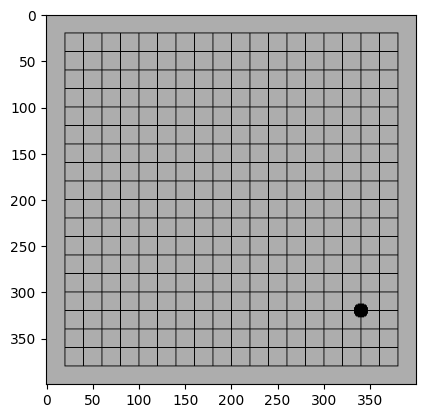

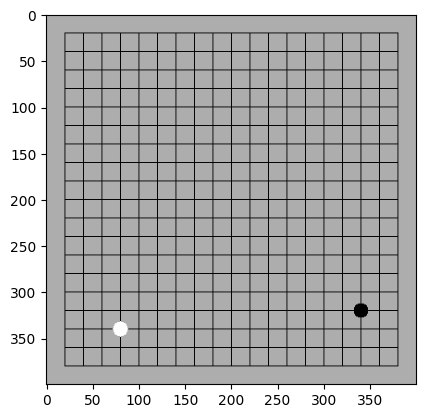

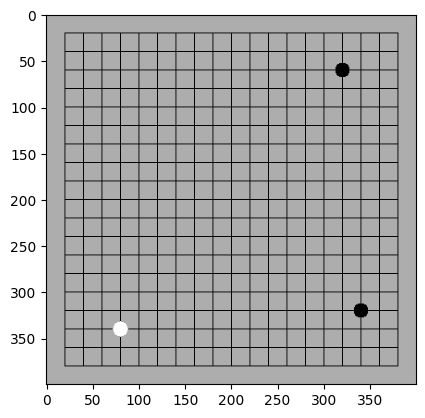

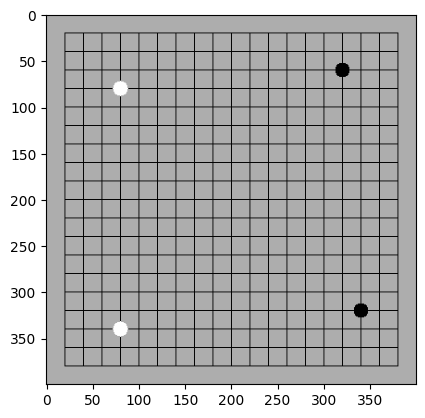

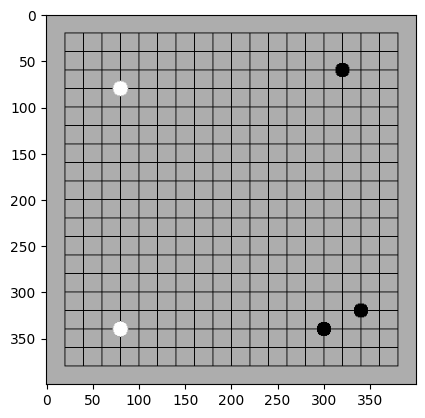

In [11]:
import matplotlib.pyplot as plt

boards = goDataset.__getitem__(0)
for i in range(5):
    plt.imshow(draw_board(boards[i]))
    plt.show()
